# TGFB Part 3 - more PCA/umap/louvain

In [1]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

results_file_adata = './write/tgfb1-3-adata.h5ad'  # the file that will store the analysis results
results_file_batch2 = './write/tgfb1-3-batch2.h5ad'  # the file that will store the analysis results

adata = anndata.read("./write/tgfb1-2.h5ad")

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Confirm PCA tool data was saved

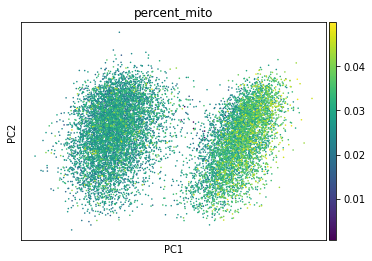

In [2]:
sc.pl.pca(adata, color='percent_mito')

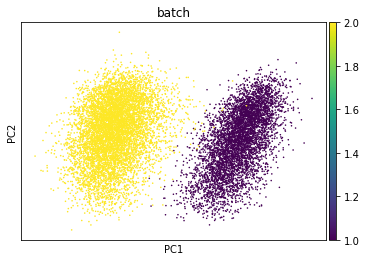

In [3]:
sc.pl.pca(adata, color='batch')

# More PCA plots

Check that TGFB1 is present

In [4]:
any(adata.var.gene_ids == "TGFB1")

True

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

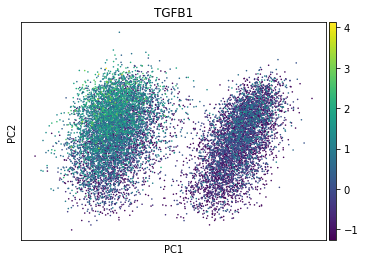

In [5]:
sc.pl.pca(adata, color='TGFB1')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

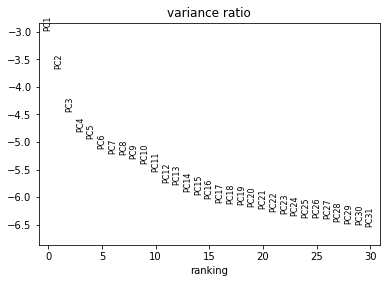

In [6]:
sc.pl.pca_variance_ratio(adata, log=True)

# Separate batch 2 data
Create a new variable for batch 2 data we can save and run different analyses on.

In [7]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [8]:
batch_2 = adata[adata.obs['batch'] == 2, :]

In [9]:
batch_2

View of AnnData object with n_obs × n_vars = 7058 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(batch_2, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:07.39) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.40) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [11]:
sc.tl.umap(adata)
sc.tl.umap(batch_2)

computing UMAP
    finished (0:00:13.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:17.17) --> added
    'X_umap', UMAP coordinates (adata.obsm)


Run umap on the entire data set and then batch 2 separately

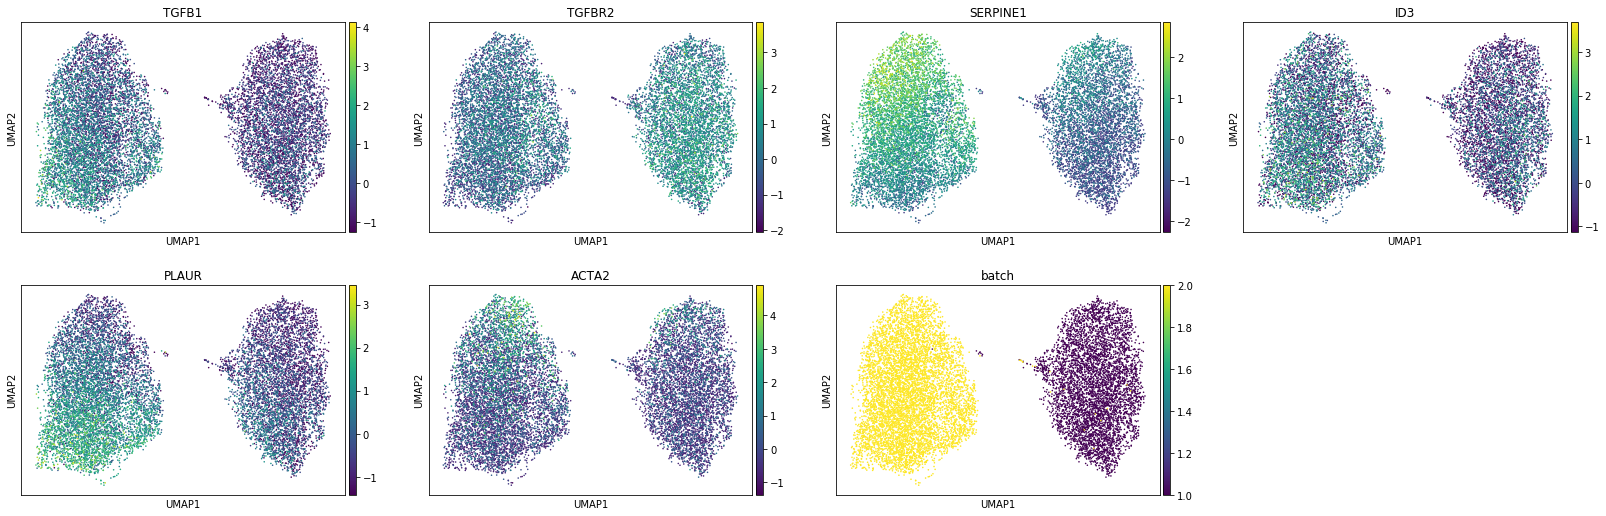

In [12]:
sc.pl.umap(adata, color=[i for i in ["TGFB1", "TGFBR1", "TGFBR2", "SERPINE1", "ID3", "PLAUR", "ACTA2"] if i in adata.var_names] + ["batch"])

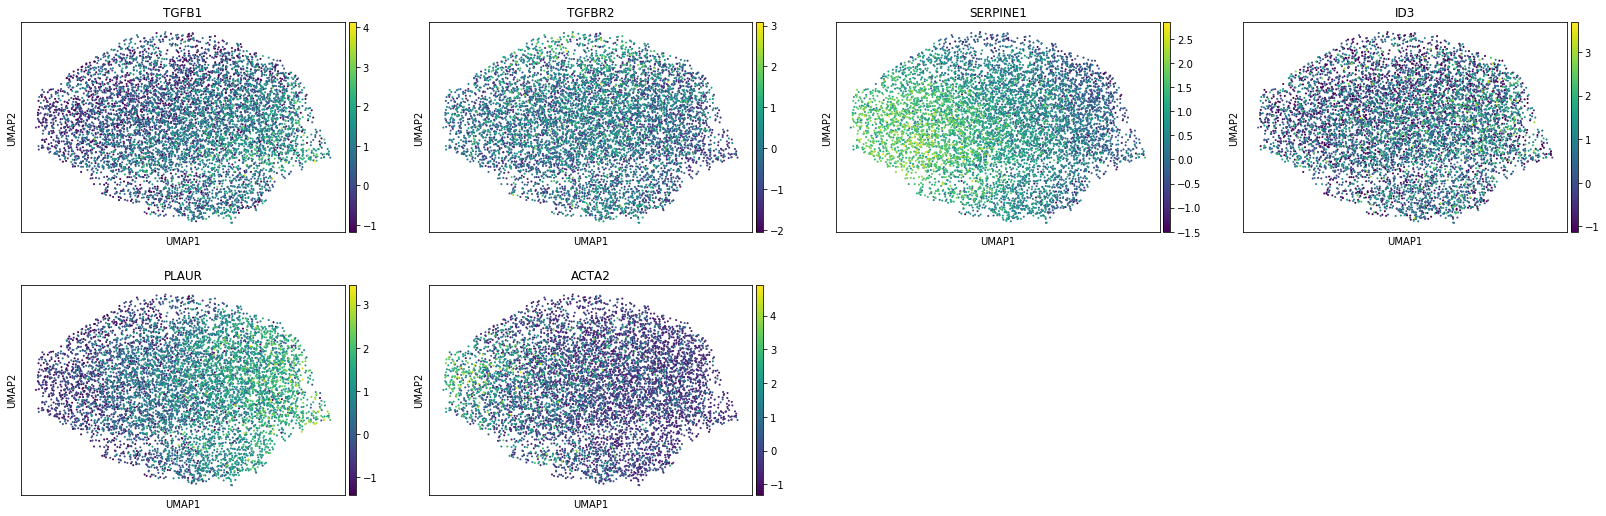

In [13]:
sc.pl.umap(batch_2, color=[i for i in ["TGFB1", "TGFBR1", "TGFBR2", "SERPINE1", "ID3", "PLAUR", "ACTA2"] if i in batch_2.var_names] )

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [14]:
scanpy.tl.louvain(adata)
scanpy.tl.louvain(batch_2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.46) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.88) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the clusters, which agree quite well with the result of Seurat. Do the same for batch 2 only.

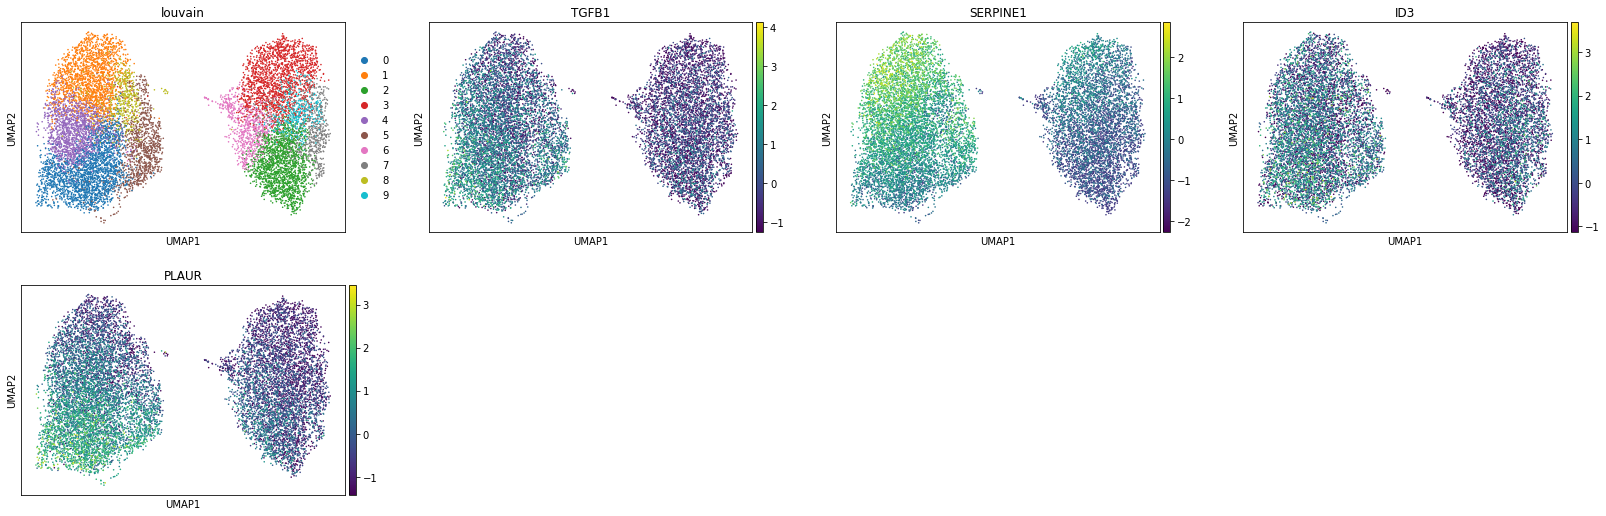

In [15]:
sc.pl.umap(adata, color=['louvain', 'TGFB1', 'SERPINE1', 'ID3', 'PLAUR'])

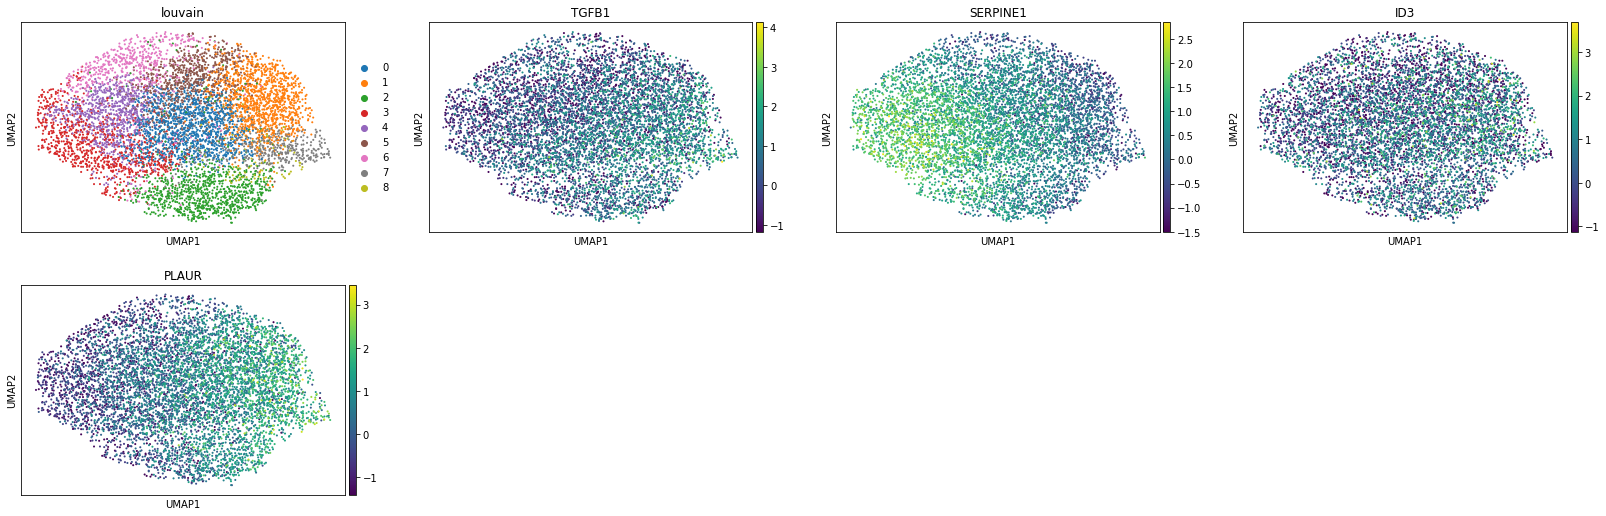

In [16]:
sc.pl.umap(batch_2, color=['louvain', 'TGFB1', 'SERPINE1', 'ID3', 'PLAUR'])

Save the result.

In [17]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [18]:
batch_2

AnnData object with n_obs × n_vars = 7058 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [19]:
adata.write(results_file_adata)
batch_2.write(results_file_batch2)